In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# STEP 1: Load the dataset
df = pd.read_csv("acc_gyr.csv")  # Change path if needed

# STEP 2: Compute vector norms for accelerometer and gyroscope
df['acc_norm'] = np.sqrt(df['xAcc']**2 + df['yAcc']**2 + df['zAcc']**2)
df['gyr_norm'] = np.sqrt(df['xGyro']**2 + df['yGyro']**2 + df['zGyro']**2)

# STEP 3: Simplify labels to "fall" or "nofall"
fall_keywords = ['fall', 'rfall', 'lfall', 'light']  # Customize if needed

def map_label(label):
    for word in fall_keywords:
        if word in label.lower():
            return 'fall'
    return 'nofall'

df['label'] = df['label'].apply(map_label)

# STEP 4: Keep only necessary columns
df_reduced = df[['acc_norm', 'gyr_norm', 'label']]

# STEP 5: Group every 400 rows into one sample
samples = len(df_reduced) // 400
X = []
y = []

for i in range(samples):
    chunk = df_reduced.iloc[i*400:(i+1)*400]

    acc_flat = chunk['acc_norm'].values  # 400 values
    gyr_flat = chunk['gyr_norm'].values  # 400 values

    # Combine into a single 800-length feature vector
    combined = np.concatenate((acc_flat, gyr_flat))
    X.append(combined)

    # Assume all 400 rows in the chunk have the same label (take first one)
    y.append(chunk['label'].values[0])

# STEP 6: Convert to numpy array and encode labels
X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)  # fall → 1, nofall → 0

# Print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


X shape: (242, 800)
y shape: (242,)
Label mapping: {np.str_('fall'): np.int64(0), np.str_('nofall'): np.int64(1)}


array(['fall', 'rfall', 'lfall', 'light', 'sit', 'walk', 'step'],
      dtype=object)

In [32]:
df_reduced.head(20)
df_reduced.to_csv('cleaned.csv')

In [30]:
df_reduced.head()

,acc_norm,gyr_norm,label
0,10.108581,4.985960,fall
1,9.537688,7.893098,fall
2,9.185761,6.751792,fall
3,9.317725,2.843343,fall
4,9.264567,1.310153,fall


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5365 - loss: 26.8368 - val_accuracy: 0.5000 - val_loss: 23.6328
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6685 - loss: 13.0741 - val_accuracy: 0.7000 - val_loss: 5.1780
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7287 - loss: 6.8083 - val_accuracy: 0.7500 - val_loss: 3.5017
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7207 - loss: 6.0630 - val_accuracy: 0.5500 - val_loss: 5.9260
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7228 - loss: 4.2872 - val_accuracy: 0.7500 - val_loss: 3.4436
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8404 - loss: 2.0213 - val_accuracy: 0.8500 - val_loss: 1.8925
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7983 - loss: 2.4829 - val_accuracy: 0.8500 - val_loss: 1.3676
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8796 - loss: 1.9195 - val_accuracy: 0.9000 - val_loss:

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


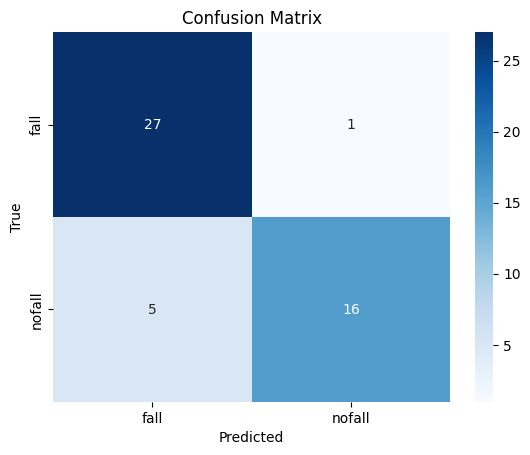

              precision    recall  f1-score   support

        fall       0.84      0.96      0.90        28
      nofall       0.94      0.76      0.84        21

    accuracy                           0.88        49
   macro avg       0.89      0.86      0.87        49
weighted avg       0.89      0.88      0.88        49



In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# STEP 2: One-hot encode labels (binary classification)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# STEP 3: Build the neural network model
model = Sequential([
    Dense(256, input_shape=(800,), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 output classes: fall, nofall
])

# STEP 4: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# STEP 5: Train the model
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=16, validation_split=0.1)

# STEP 6: Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# STEP 7: Confusion matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fall', 'nofall'], yticklabels=['fall', 'nofall'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['fall', 'nofall']))


In [35]:
model.save('fall_detection_model.keras')

